In [1]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Class map for translation
CLASS_MAP = {
    "huahen": "scratch",
    "liewen": "crack",
    "baidian": "spot",
    "louguang": "light-leakage",
    "bengque": "broken",
    "wuzi": "blot",
    "pomo": "broken-membrane",
    "ok": "no-defect"
}

# Crack severity classification
CRACK_SEVERITY_MAP = {
    "no-defect": "no_crack",
    "spot": "small_crack",
    "scratch": "small_crack",
    "blot": "small_crack",
    "light-leakage": "small_crack",
    "crack": "heavy_crack",
    "broken": "heavy_crack",
    "broken-membrane": "heavy_crack"
}

# Dataset Paths
DATASET_DIR = r"C:\\Users\\anant\\Downloads\\SSGD\\SSGD"
IMAGE_DIRS = ['lb101', 'lb201']

In [2]:
# Cell 2: Parse XML and Load Image Paths with Labels
image_data = []  # Holds all parsed info
class_counter = defaultdict(int)
severity_counter = defaultdict(int)

for folder in IMAGE_DIRS:
    img_dir = Path(DATASET_DIR) / folder
    for file in os.listdir(img_dir):
        if file.endswith(".xml"):
            xml_path = img_dir / file
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()
                img_filename = root.find("filename").text
                img_path = img_dir / img_filename

                labels_in_image = set()
                for obj in root.findall("object"):
                    label_pinyin = obj.find("name").text.strip().lower()
                    label_english = CLASS_MAP.get(label_pinyin, "unknown")
                    severity = CRACK_SEVERITY_MAP.get(label_english, "unknown")

                    class_counter[label_english] += 1
                    severity_counter[severity] += 1
                    labels_in_image.add(severity)

                image_data.append({
                    "image_path": str(img_path),
                    "labels": list(labels_in_image)
                })
            except Exception as e:
                print(f"Error parsing {xml_path}: {e}")

In [4]:
IMG_SIZE = (128, 128)
X, y = [], []

SEVERITY_CLASS_MAP = {
    "no_crack": 0,
    "small_crack": 1,
    "heavy_crack": 2
}

for item in image_data:
    try:
        img = Image.open(item["image_path"]).convert("RGB")
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        label = SEVERITY_CLASS_MAP[item['labels'][0]]
        X.append(img_array)
        y.append(label)
    except Exception as e:
        print(f"Error loading image {item['image_path']}: {e}")

X = np.array(X)
y = to_categorical(y, num_classes=3)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Unfreeze entire base first

# Freeze the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation(tf.nn.swish)(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(tf.nn.swish)(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=10, verbose=1),
    ModelCheckpoint("best_mobilenetv2_model_updated.h5", save_best_only=True, monitor='val_accuracy', verbose=1)
]

In [22]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4147 - loss: 1.2053
Epoch 1: val_accuracy improved from -inf to 0.49867, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 665ms/step - accuracy: 0.4154 - loss: 1.2043 - val_accuracy: 0.4987 - val_loss: 1.0583 - learning_rate: 1.0000e-04
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5530 - loss: 0.9446
Epoch 2: val_accuracy did not improve from 0.49867
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.5531 - loss: 0.9448 - val_accuracy: 0.4734 - val_loss: 1.0595 - learning_rate: 1.0000e-04
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5817 - loss: 0.9265
Epoch 3: val_accuracy improved from 0.49867 to 0.51064, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.5819 - loss: 0.9260 - val_accuracy: 0.5106 - val_loss: 1.0704 - learning_rate: 1.0000e-04
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6080 - loss: 0.8652
Epoch 4: val_accuracy did not improve from 0.51064
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 578ms/step - accuracy: 0.6083 - loss: 0.8649 - val_accuracy: 0.4348 - val_loss: 1.1569 - learning_rate: 1.0000e-04
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6502 - loss: 0.7889
Epoch 5: val_accuracy did not improve from 0.51064
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.6502 - loss: 0.7891 - val_accuracy: 0.4707 - val_loss: 1.1134 - learning_rate: 1.0000e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6804 - loss: 0.7550
Epoch 6: val_accuracy did not improve from 0.51064
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - accuracy: 0.6802 - loss: 0.7554 - val_accuracy: 0.4189 - val_loss: 1.2065 - learning_rate: 1.0000e-04
Ep

55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.7520 - loss: 0.5969 - val_accuracy: 0.5199 - val_loss: 1.2058 - learning_rate: 3.0000e-05
Epoch 16/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7372 - loss: 0.6172
Epoch 16: val_accuracy did not improve from 0.51995
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.7373 - loss: 0.6173 - val_accuracy: 0.5013 - val_loss: 1.2989 - learning_rate: 3.0000e-05
Epoch 17/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7582 - loss: 0.5758
Epoch 17: val_accuracy improved from 0.51995 to 0.53324, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 602ms/step - accuracy: 0.7585 - loss: 0.5757 - val_accuracy: 0.5332 - val_loss: 1.2510 - learning_rate: 3.0000e-05
Epoch 18/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.7568 - loss: 0.6023
Epoch 18: val_accuracy improved from 0.53324 to 0.55186, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - accuracy: 0.7567 - loss: 0.6021 - val_accuracy: 0.5519 - val_loss: 1.1828 - learning_rate: 3.0000e-05
Epoch 19/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7498 - loss: 0.5759
Epoch 19: val_accuracy improved from 0.55186 to 0.57979, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 594ms/step - accuracy: 0.7499 - loss: 0.5760 - val_accuracy: 0.5798 - val_loss: 1.1010 - learning_rate: 3.0000e-05
Epoch 20/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7601 - loss: 0.5634
Epoch 20: val_accuracy improved from 0.57979 to 0.58245, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 550ms/step - accuracy: 0.7603 - loss: 0.5633 - val_accuracy: 0.5824 - val_loss: 1.1208 - learning_rate: 3.0000e-05
Epoch 21/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7430 - loss: 0.6238
Epoch 21: val_accuracy did not improve from 0.58245
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 559ms/step - accuracy: 0.7432 - loss: 0.6234 - val_accuracy: 0.5731 - val_loss: 1.1948 - learning_rate: 3.0000e-05
Epoch 22/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7503 - loss: 0.6053
Epoch 22: val_accuracy improved from 0.58245 to 0.60239, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.7503 - loss: 0.6051 - val_accuracy: 0.6024 - val_loss: 1.0861 - learning_rate: 3.0000e-05
Epoch 23/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7531 - loss: 0.5844
Epoch 23: val_accuracy improved from 0.60239 to 0.62766, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 569ms/step - accuracy: 0.7533 - loss: 0.5840 - val_accuracy: 0.6277 - val_loss: 1.0028 - learning_rate: 3.0000e-05
Epoch 24/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7749 - loss: 0.5505
Epoch 24: val_accuracy did not improve from 0.62766
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 571ms/step - accuracy: 0.7749 - loss: 0.5505 - val_accuracy: 0.6223 - val_loss: 1.0271 - learning_rate: 3.0000e-05
Epoch 25/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7897 - loss: 0.5355
Epoch 25: val_accuracy improved from 0.62766 to 0.65293, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.7897 - loss: 0.5356 - val_accuracy: 0.6529 - val_loss: 0.9567 - learning_rate: 3.0000e-05
Epoch 26/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7660 - loss: 0.5576
Epoch 26: val_accuracy improved from 0.65293 to 0.69016, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 574ms/step - accuracy: 0.7662 - loss: 0.5575 - val_accuracy: 0.6902 - val_loss: 0.8537 - learning_rate: 3.0000e-05
Epoch 27/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7809 - loss: 0.5299
Epoch 27: val_accuracy did not improve from 0.69016
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - accuracy: 0.7809 - loss: 0.5300 - val_accuracy: 0.6888 - val_loss: 0.9084 - learning_rate: 3.0000e-05
Epoch 28/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7799 - loss: 0.5442
Epoch 28: val_accuracy did not improve from 0.69016
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.7798 - loss: 0.5444 - val_accuracy: 0.6809 - val_loss: 0.9903 - learning_rate: 3.0000e-05
Epoch 29/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7701 - loss: 0.5513
Epoch 29: val_accuracy did not improve from 0.69016
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.7699 - loss: 0.5513 - val_accuracy: 0.6822 - val_loss: 0.9919 - learning_rate: 3.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 570ms/step - accuracy: 0.7700 - loss: 0.5609 - val_accuracy: 0.6968 - val_loss: 0.9353 - learning_rate: 3.0000e-05
Epoch 32/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8042 - loss: 0.4977
Epoch 32: val_accuracy improved from 0.69681 to 0.70346, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 559ms/step - accuracy: 0.8041 - loss: 0.4980 - val_accuracy: 0.7035 - val_loss: 0.9534 - learning_rate: 3.0000e-05
Epoch 33/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7672 - loss: 0.5653
Epoch 33: val_accuracy improved from 0.70346 to 0.70612, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.7672 - loss: 0.5654 - val_accuracy: 0.7061 - val_loss: 0.8822 - learning_rate: 3.0000e-05
Epoch 34/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8048 - loss: 0.4921
Epoch 34: val_accuracy improved from 0.70612 to 0.72872, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8048 - loss: 0.4922 - val_accuracy: 0.7287 - val_loss: 0.8128 - learning_rate: 3.0000e-05
Epoch 35/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7941 - loss: 0.5195
Epoch 35: val_accuracy did not improve from 0.72872
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 562ms/step - accuracy: 0.7940 - loss: 0.5193 - val_accuracy: 0.7274 - val_loss: 0.7947 - learning_rate: 3.0000e-05
Epoch 36/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.7969 - loss: 0.5008
Epoch 36: val_accuracy improved from 0.72872 to 0.73936, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step - accuracy: 0.7967 - loss: 0.5013 - val_accuracy: 0.7394 - val_loss: 0.7603 - learning_rate: 3.0000e-05
Epoch 37/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8002 - loss: 0.5107
Epoch 37: val_accuracy improved from 0.73936 to 0.75266, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 577ms/step - accuracy: 0.8002 - loss: 0.5105 - val_accuracy: 0.7527 - val_loss: 0.6491 - learning_rate: 3.0000e-05
Epoch 38/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8101 - loss: 0.4803
Epoch 38: val_accuracy improved from 0.75266 to 0.76862, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 572ms/step - accuracy: 0.8099 - loss: 0.4808 - val_accuracy: 0.7686 - val_loss: 0.6101 - learning_rate: 3.0000e-05
Epoch 39/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8150 - loss: 0.4479
Epoch 39: val_accuracy did not improve from 0.76862
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.8149 - loss: 0.4483 - val_accuracy: 0.7593 - val_loss: 0.6317 - learning_rate: 3.0000e-05
Epoch 40/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8106 - loss: 0.4880
Epoch 40: val_accuracy improved from 0.76862 to 0.76995, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.8106 - loss: 0.4878 - val_accuracy: 0.7699 - val_loss: 0.6226 - learning_rate: 3.0000e-05
Epoch 41/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7848 - loss: 0.5189
Epoch 41: val_accuracy did not improve from 0.76995
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 547ms/step - accuracy: 0.7850 - loss: 0.5187 - val_accuracy: 0.7646 - val_loss: 0.6270 - learning_rate: 3.0000e-05
Epoch 42/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8203 - loss: 0.4772
Epoch 42: val_accuracy did not improve from 0.76995
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.8201 - loss: 0.4775 - val_accuracy: 0.7699 - val_loss: 0.5971 - learning_rate: 3.0000e-05
Epoch 43/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7952 - loss: 0.5090
Epoch 43: val_accuracy improved from 0.76995 to 0.78191, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 577ms/step - accuracy: 0.7952 - loss: 0.5089 - val_accuracy: 0.7819 - val_loss: 0.5962 - learning_rate: 3.0000e-05
Epoch 44/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.7960 - loss: 0.4990
Epoch 44: val_accuracy did not improve from 0.78191
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.7960 - loss: 0.4989 - val_accuracy: 0.7726 - val_loss: 0.6376 - learning_rate: 3.0000e-05
Epoch 45/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8060 - loss: 0.4739
Epoch 45: val_accuracy did not improve from 0.78191
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.8061 - loss: 0.4739 - val_accuracy: 0.7620 - val_loss: 0.6553 - learning_rate: 3.0000e-05
Epoch 46/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8271 - loss: 0.4667
Epoch 46: val_accuracy did not improve from 0.78191
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - accuracy: 0.8269 - loss: 0.4670 - val_accuracy: 0.7620 - val_loss: 0.6809 - learning_rate: 3.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.8053 - loss: 0.5149 - val_accuracy: 0.7912 - val_loss: 0.5712 - learning_rate: 3.0000e-05
Epoch 50/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8249 - loss: 0.4411
Epoch 50: val_accuracy did not improve from 0.79122
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 578ms/step - accuracy: 0.8247 - loss: 0.4416 - val_accuracy: 0.7832 - val_loss: 0.6041 - learning_rate: 3.0000e-05
Epoch 51/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8239 - loss: 0.4501
Epoch 51: val_accuracy improved from 0.79122 to 0.79255, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 597ms/step - accuracy: 0.8238 - loss: 0.4503 - val_accuracy: 0.7926 - val_loss: 0.5484 - learning_rate: 3.0000e-05
Epoch 52/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8066 - loss: 0.4565
Epoch 52: val_accuracy improved from 0.79255 to 0.79521, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 576ms/step - accuracy: 0.8066 - loss: 0.4567 - val_accuracy: 0.7952 - val_loss: 0.5523 - learning_rate: 3.0000e-05
Epoch 53/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8025 - loss: 0.4785
Epoch 53: val_accuracy did not improve from 0.79521
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - accuracy: 0.8028 - loss: 0.4781 - val_accuracy: 0.7899 - val_loss: 0.5584 - learning_rate: 3.0000e-05
Epoch 54/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8252 - loss: 0.4530
Epoch 54: val_accuracy improved from 0.79521 to 0.79920, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.8251 - loss: 0.4531 - val_accuracy: 0.7992 - val_loss: 0.5711 - learning_rate: 3.0000e-05
Epoch 55/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8316 - loss: 0.4405
Epoch 55: val_accuracy did not improve from 0.79920
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - accuracy: 0.8314 - loss: 0.4405 - val_accuracy: 0.7992 - val_loss: 0.5553 - learning_rate: 3.0000e-05
Epoch 56/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8037 - loss: 0.4628
Epoch 56: val_accuracy improved from 0.79920 to 0.80319, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.8038 - loss: 0.4628 - val_accuracy: 0.8032 - val_loss: 0.5495 - learning_rate: 3.0000e-05
Epoch 57/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8421 - loss: 0.4335
Epoch 57: val_accuracy improved from 0.80319 to 0.80452, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.8420 - loss: 0.4333 - val_accuracy: 0.8045 - val_loss: 0.5510 - learning_rate: 3.0000e-05
Epoch 58/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8270 - loss: 0.4564
Epoch 58: val_accuracy did not improve from 0.80452
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 560ms/step - accuracy: 0.8269 - loss: 0.4564 - val_accuracy: 0.7926 - val_loss: 0.5583 - learning_rate: 3.0000e-05
Epoch 59/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8317 - loss: 0.4356
Epoch 59: val_accuracy improved from 0.80452 to 0.81383, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 573ms/step - accuracy: 0.8317 - loss: 0.4356 - val_accuracy: 0.8138 - val_loss: 0.5321 - learning_rate: 3.0000e-05
Epoch 60/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8465 - loss: 0.4121
Epoch 60: val_accuracy did not improve from 0.81383
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - accuracy: 0.8464 - loss: 0.4124 - val_accuracy: 0.8138 - val_loss: 0.5214 - learning_rate: 3.0000e-05
Epoch 61/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8224 - loss: 0.4249
Epoch 61: val_accuracy did not improve from 0.81383
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 569ms/step - accuracy: 0.8223 - loss: 0.4251 - val_accuracy: 0.8045 - val_loss: 0.5339 - learning_rate: 3.0000e-05
Epoch 62/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8124 - loss: 0.4442
Epoch 62: val_accuracy did not improve from 0.81383
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8124 - loss: 0.4444 - val_accuracy: 0.8005 - val_loss: 0.5354 - learning_rate: 3.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 584ms/step - accuracy: 0.8550 - loss: 0.3806 - val_accuracy: 0.8165 - val_loss: 0.5265 - learning_rate: 9.0000e-06
Epoch 71/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8501 - loss: 0.3709
Epoch 71: val_accuracy did not improve from 0.81649
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 571ms/step - accuracy: 0.8499 - loss: 0.3714 - val_accuracy: 0.8152 - val_loss: 0.5307 - learning_rate: 9.0000e-06
Epoch 72/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8394 - loss: 0.4083
Epoch 72: val_accuracy improved from 0.81649 to 0.81915, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.8394 - loss: 0.4081 - val_accuracy: 0.8191 - val_loss: 0.5285 - learning_rate: 9.0000e-06
Epoch 73/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8325 - loss: 0.4470
Epoch 73: val_accuracy did not improve from 0.81915
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 571ms/step - accuracy: 0.8326 - loss: 0.4467 - val_accuracy: 0.8152 - val_loss: 0.5322 - learning_rate: 9.0000e-06
Epoch 74/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8458 - loss: 0.3961
Epoch 74: val_accuracy improved from 0.81915 to 0.82447, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 570ms/step - accuracy: 0.8458 - loss: 0.3960 - val_accuracy: 0.8245 - val_loss: 0.5307 - learning_rate: 9.0000e-06
Epoch 75/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8367 - loss: 0.4149
Epoch 75: val_accuracy did not improve from 0.82447
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 554ms/step - accuracy: 0.8365 - loss: 0.4155 - val_accuracy: 0.8191 - val_loss: 0.5327 - learning_rate: 9.0000e-06
Epoch 76/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8418 - loss: 0.4088
Epoch 76: val_accuracy did not improve from 0.82447
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.8420 - loss: 0.4086 - val_accuracy: 0.8178 - val_loss: 0.5364 - learning_rate: 9.0000e-06
Epoch 77/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8588 - loss: 0.3713
Epoch 77: val_accuracy did not improve from 0.82447
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 558ms/step - accuracy: 0.8585 - loss: 0.3718 - val_accuracy: 0.8245 - val_loss: 0.5310 - learning_rate: 9.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 582ms/step - accuracy: 0.8424 - loss: 0.3974 - val_accuracy: 0.8258 - val_loss: 0.5200 - learning_rate: 9.0000e-06
Epoch 82/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8342 - loss: 0.4121
Epoch 82: val_accuracy improved from 0.82580 to 0.82846, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 566ms/step - accuracy: 0.8342 - loss: 0.4120 - val_accuracy: 0.8285 - val_loss: 0.5200 - learning_rate: 9.0000e-06
Epoch 83/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8480 - loss: 0.3992
Epoch 83: val_accuracy did not improve from 0.82846
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 556ms/step - accuracy: 0.8478 - loss: 0.3994 - val_accuracy: 0.8285 - val_loss: 0.5220 - learning_rate: 9.0000e-06
Epoch 84/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8465 - loss: 0.3923
Epoch 84: val_accuracy did not improve from 0.82846
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.8464 - loss: 0.3926 - val_accuracy: 0.8271 - val_loss: 0.5282 - learning_rate: 9.0000e-06
Epoch 85/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8468 - loss: 0.3990
Epoch 85: val_accuracy improved from 0.82846 to 0.83112, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.8469 - loss: 0.3989 - val_accuracy: 0.8311 - val_loss: 0.5329 - learning_rate: 9.0000e-06
Epoch 86/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8594 - loss: 0.3787
Epoch 86: val_accuracy improved from 0.83112 to 0.83245, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 585ms/step - accuracy: 0.8593 - loss: 0.3787 - val_accuracy: 0.8324 - val_loss: 0.5239 - learning_rate: 9.0000e-06
Epoch 87/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8582 - loss: 0.3757
Epoch 87: val_accuracy improved from 0.83245 to 0.83777, saving model to best_mobilenetv2_model_updated.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.8580 - loss: 0.3761 - val_accuracy: 0.8378 - val_loss: 0.5238 - learning_rate: 9.0000e-06
Epoch 88/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8430 - loss: 0.3960
Epoch 88: val_accuracy did not improve from 0.83777
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.8429 - loss: 0.3964 - val_accuracy: 0.8364 - val_loss: 0.5235 - learning_rate: 9.0000e-06
Epoch 89/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8787 - loss: 0.3642
Epoch 89: val_accuracy did not improve from 0.83777
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8785 - loss: 0.3644 - val_accuracy: 0.8364 - val_loss: 0.5191 - learning_rate: 9.0000e-06
Epoch 90/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8527 - loss: 0.3676
Epoch 90: val_accuracy did not improve from 0.83777
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8527 - loss: 0.3678 - val_accuracy: 0.8351 - val_loss: 0.5163 - learning_rate: 9.0000e

In [23]:
# Cell 9: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8457 - loss: 0.5006
Test Accuracy: 83.78%


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step
              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.92       249
     Class 1       0.78      0.87      0.82       275
     Class 2       0.82      0.70      0.76       228

    accuracy                           0.84       752
   macro avg       0.84      0.83      0.83       752
weighted avg       0.84      0.84      0.84       752

Confusion Matrix:
[[232   6  11]
 [ 13 239  23]
 [  8  61 159]]


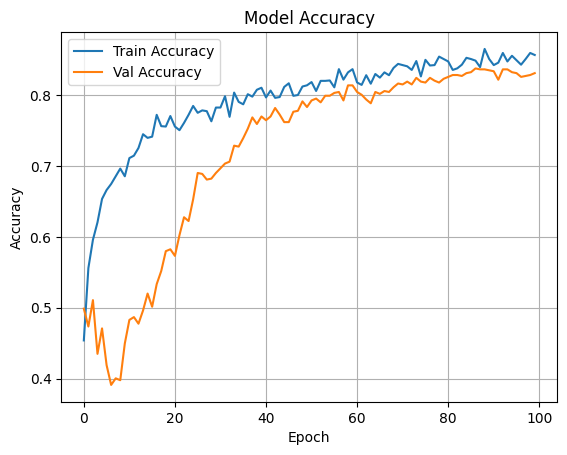

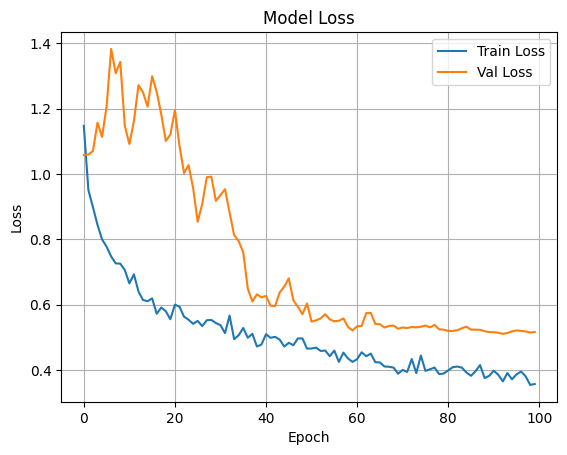

In [25]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step


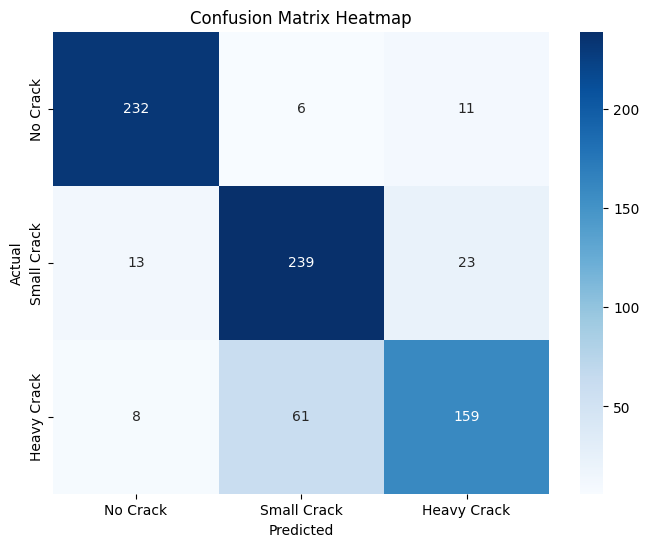

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_names = ['No Crack', 'Small Crack', 'Heavy Crack']  # Update if needed

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


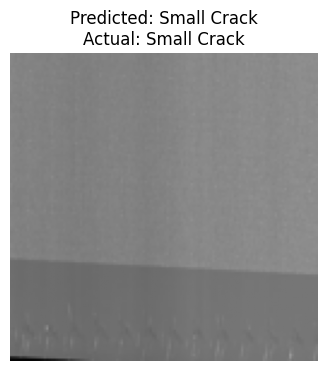

In [37]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Class labels mapping
class_names = ['No Crack', 'Small Crack', 'Heavy Crack']

# Pick a random index from the test set
idx = random.randint(0, len(X_test) - 1)

# Get the image and its true label
sample_image = X_test[idx]
true_label = np.argmax(y_test[idx])

# Expand dimensions and predict
pred_probs = model.predict(np.expand_dims(sample_image, axis=0))
pred_label = np.argmax(pred_probs)

# Plot the image with prediction info
plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.axis('off')
plt.title(f"Predicted: {class_names[pred_label]}\nActual: {class_names[true_label]}")
plt.show()

In [32]:
confidence = pred_probs[0][pred_label] * 100
print(f"Confidence: {confidence:.2f}%")

Confidence: 99.97%


In [35]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step
              precision    recall  f1-score   support

    No Crack       0.92      0.93      0.92       249
 Small Crack       0.78      0.87      0.82       275
 Heavy Crack       0.82      0.70      0.76       228

    accuracy                           0.84       752
   macro avg       0.84      0.83      0.83       752
weighted avg       0.84      0.84      0.84       752



In [2]:
from collections import Counter
print(Counter([item['labels'][0] for item in image_data]))

NameError: name 'image_data' is not defined

In [44]:
# Save the full model (architecture + weights + optimizer state)
model.save("mobilenetv2_crack_detector.h5")
print("model saved!")

model saved!
